# PyMC3のテスト


## 単純なベイジアン線形回帰モデルを検討する

\begin{split}\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}\end{split}

ベイジアンモデルを構築しているので、モデル内の未知の変数に事前分布を割り当てる必要があります。

Nの中身、つまり平均を0, 分散を100を割り当てます。

半正規分布（ゼロで囲まれた正規分布）を選択します。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Text(0.5,0,'X2')

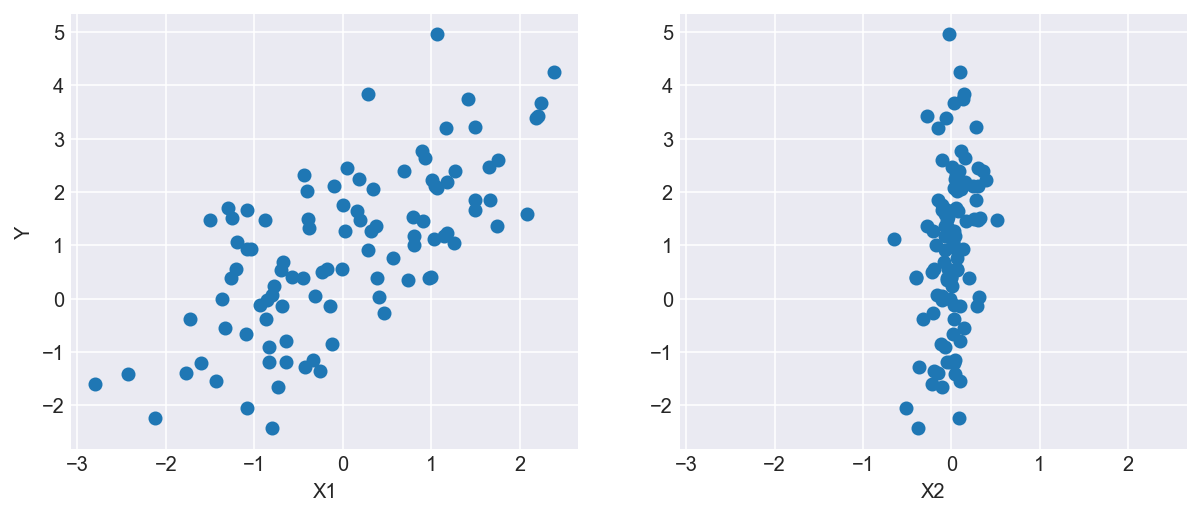

In [2]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2')

In [3]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [5]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1228.26it/s] 


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

In [6]:
map_estimate = pm.find_MAP(model=basic_model, method='powell')

map_estimate

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:502: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 2583.45it/s] 


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma_log__': array(-0.03492212),
 'sigma': array(0.96568062)}

In [7]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3427.90draws/s]


In [8]:
trace['alpha'][-5:]

array([0.9022226 , 0.87236601, 0.96473987, 0.79315611, 0.67644667])

In [9]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 2753.58draws/s]


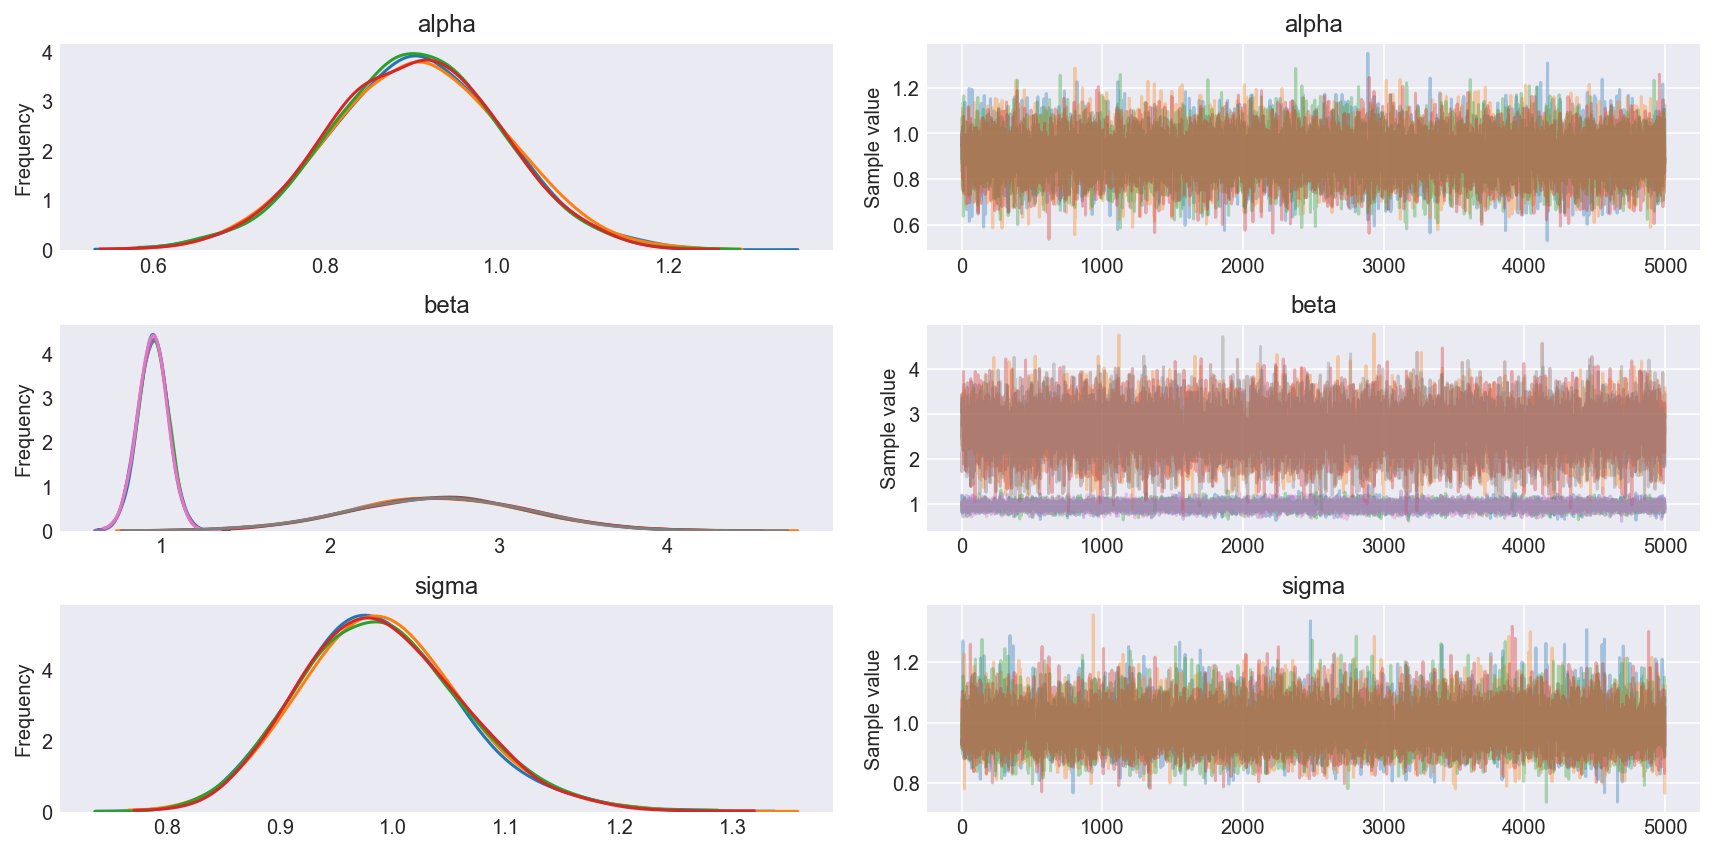

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.0,0.72,1.11,19979.81,1.0
beta__0,0.95,0.09,0.0,0.78,1.13,19107.16,1.0
beta__1,2.65,0.52,0.0,1.60,3.65,16191.09,1.0
sigma,0.99,0.07,0.0,0.86,1.13,17898.13,1.0


# 階層ベイズモデルでイングランドのプレミアムリーグを予想する

- 潜在的なパラメータ、つまりチームの「強さ」を測ることで、どこのチームが優勝候補かを知りたいと考えています。
- 利用するデータは、得点（ホームとアウェイ）と結果です。
- Teamの強さを正確に測定しているものでなく、あくまで「得点の強さ」だけに基づいています。

- 階層ベイズモデルは、この強さをモデル化するための優れたアプローチと考えられます。
- というのも、ゴールはそれだけ起こる確率が低いものと想定され、ポアソン分布がふさわしいと考えられるからです。
- ゴールは、起こる確率が常にランダムでありながら、単位時間あたり平均 λ回起こるようなランダムな事象が，単位時間に k回起きる確率と考えられ、この確率分布自体がポアソン分布であると言えます。

- 答えは、一つではなく、それぞれのチームの優勝候補の可能性や分布という形で得たい


In [12]:
import os
import math
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import StrMethodFormatter

from IPython.display import Image, HTML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pymc

# Import Dataset from wikipedia
(https://en.wikipedia.org/wiki/2013–14_Premier_League)

In [13]:
result = pd.read_csv('result.csv')
result.head(100)

,Home \ Away,ARS,AST,CAR,CHE,CRY,EVE,FUL,HUL,LIV,...,MUN,NEW,NOR,SOU,STK,SUN,SWA,TOT,WBA,WHU
0,Arsenal,—,1–3,2–0,0–0,2–0,1–1,2–0,2–0,2–0,...,0–0,3–0,4–1,2–0,3–1,4–1,2–2,1–0,1–0,3–1
1,Aston Villa,1–2,—,2–0,1–0,0–1,0–2,1–2,3–1,0–1,...,0–3,1–2,4–1,0–0,1–4,0–0,1–1,0–2,4–3,0–2
2,Cardiff City,0–3,0–0,—,1–2,0–3,0–0,3–1,0–4,3–6,...,2–2,1–2,2–1,0–3,1–1,2–2,1–0,0–1,1–0,0–2
3,Chelsea,6–0,2–1,4–1,—,2–1,1–0,2–0,2–0,2–1,...,3–1,3–0,0–0,3–1,3–0,1–2,1–0,4–0,2–2,0–0
4,Crystal Palace,0–2,1–0,2–0,1–0,—,0–0,1–4,1–0,3–3,...,0–2,0–3,1–1,0–1,1–0,3–1,0–2,0–1,3–1,1–0
5,Everton,3–0,2–1,2–1,1–0,2–3,—,4–1,2–1,3–3,...,2–0,3–2,2–0,2–1,4–0,0–1,3–2,0–0,0–0,1–0
6,Fulham,1–3,2–0,1–2,1–3,2–2,1–3,—,2–2,2–3,...,1–3,1–0,1–0,0–3,1–0,1–4,1–2,1–2,1–1,2–1
7,Hull City,0–3,0–0,1–1,0–2,0–1,0–2,6–0,—,3–1,...,2–3,1–4,1–0,0–1,0–0,1–0,1–0,1–1,2–0,1–0
8,Liverpool,5–1,2–2,3–1,0–2,3–1,4–0,4–0,2–0,—,...,1–0,2–1,5–1,0–1,1–0,2–1,4–3,4–0,4–1,4–1
9,Manchester City,6–3,4–0,4–2,0–1,1–0,3–1,5–0,2–0,2–1,...,4–1,4–0,7–0,4–1,1–0,2–2,3–0,6–0,3–1,2–0


## 結果データを加工します（１行に全ての試合結果をまとめる）

In [14]:
#result=pd.read_csv('result.csv', sep='\t', index_col=0)
result=pd.read_csv('result.csv', index_col=0)

In [15]:
result.columns

Index(['ARS', 'AST', 'CAR', 'CHE', 'CRY', 'EVE', 'FUL', 'HUL', 'LIV', 'MCI',
       'MUN', 'NEW', 'NOR', 'SOU', 'STK', 'SUN', 'SWA', 'TOT', 'WBA', 'WHU'],
      dtype='object')

In [16]:
result.index

Index(['Arsenal', 'Aston Villa', 'Cardiff City', 'Chelsea', 'Crystal Palace',
       'Everton', 'Fulham', 'Hull City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Newcastle United', 'Norwich City', 'Southampton',
       'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hotspur',
       'West Bromwich Albion', 'West Ham United'],
      dtype='object', name='Home \ Away')

In [17]:
result.index=result.columns

In [18]:
result.head()

,ARS,AST,CAR,CHE,CRY,EVE,FUL,HUL,LIV,MCI,MUN,NEW,NOR,SOU,STK,SUN,SWA,TOT,WBA,WHU
ARS,—,1–3,2–0,0–0,2–0,1–1,2–0,2–0,2–0,1–1,0–0,3–0,4–1,2–0,3–1,4–1,2–2,1–0,1–0,3–1
AST,1–2,—,2–0,1–0,0–1,0–2,1–2,3–1,0–1,3–2,0–3,1–2,4–1,0–0,1–4,0–0,1–1,0–2,4–3,0–2
CAR,0–3,0–0,—,1–2,0–3,0–0,3–1,0–4,3–6,3–2,2–2,1–2,2–1,0–3,1–1,2–2,1–0,0–1,1–0,0–2
CHE,6–0,2–1,4–1,—,2–1,1–0,2–0,2–0,2–1,2–1,3–1,3–0,0–0,3–1,3–0,1–2,1–0,4–0,2–2,0–0
CRY,0–2,1–0,2–0,1–0,—,0–0,1–4,1–0,3–3,0–2,0–2,0–3,1–1,0–1,1–0,3–1,0–2,0–1,3–1,1–0


In [19]:
rows = []
for i in result.index:
    for c in result.columns:
        if i == c: continue
        score = result.ix[i, c]
        rows.append([i, c, score])
result_df = pd.DataFrame(rows, columns = ['home', 'away', 'score'])
result_df.head()

,home,away,score
0,ARS,AST,1–3
1,ARS,CAR,2–0
2,ARS,CHE,0–0
3,ARS,CRY,2–0
4,ARS,EVE,1–1


In [20]:
df = pd.concat([result_df, result_df['score'].str.split('–', expand=True)], axis=1).drop('score', axis=1)
df.rename(columns={0: 'home_score', 1: 'away_score'}, inplace=True)
df.head()

,home,away,home_score,away_score
0,ARS,AST,1,3
1,ARS,CAR,2,0
2,ARS,CHE,0,0
3,ARS,CRY,2,0
4,ARS,EVE,1,1


In [21]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,ARS,0
1,AST,1
2,CAR,2
3,CHE,3
4,CRY,4


In [ ]:
# その他のvalueなどを変数化しておく

In [22]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head(30)

,home,away,home_score,away_score,i_home,i_away
0,ARS,AST,1,3,0,1
1,ARS,CAR,2,0,0,2
2,ARS,CHE,0,0,0,3
3,ARS,CRY,2,0,0,4
4,ARS,EVE,1,1,0,5
5,ARS,FUL,2,0,0,6
6,ARS,HUL,2,0,0,7
7,ARS,LIV,2,0,0,8
8,ARS,MCI,1,1,0,9
9,ARS,MUN,0,0,0,10


## その他のvalueなどを変数化しておく

In [23]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [24]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams

,team
0,ARS
1,AST
2,CAR
3,CHE
4,CRY
5,EVE
6,FUL
7,HUL
8,LIV
9,MCI


# モデル構築

サッカーのゴール数はポアソン分布に従う。

ポアソン分布とは、[単位時間あたり平均 λ回起こるようなランダムな事象が，単位時間に k回起きる確率]


アマゾンでの事例：とある商品は最初の10日で3個しか売れませんでした。ですが、本来は２ヶ月（60日）で60個売れる算段を立てて在庫（２ヶ月分の在庫）を調達していたのです。つまり、1日で1個です。

このペースが今後も続きそうだと仮定した場合、次の1日で1個売れる確率はどれくらいあるか。個数が0個の確率は約5%、1個の確率は約15%、2個の確率は約22%…10個も売れる確率は約0.1%です。これを用いると売れない商品がどういう商品かわかるので、そのような商品ばかりを集めたセンターを作りました。

他にも、「ある田舎のお店の来店客数」、「ある交差点で1時間に起こる事故の件数」、「1ページの文章を入力する時に打ち間違いを起こす回数、、「馬に蹴られて死亡する回数」など、発生する確率が低く、かつそれが偶然に発生する事象が対象になります。このことから、「少数の法則」とも呼ばれます。


事象そのものが起こる確率は常にランダムでありながらある期間において一定であるほど、ポアソン分布は有効だと考えられています。

サッカーのゴールはそれだけ起こる確率が常にランダムでありながら、単位時間あたり平均 λ回起こるようなランダムな事象が，単位時間に k回起きる確率はあると考えられます。

ポアソン分布のパラメータであるλをいかに推定するかという問題になるわけですが、以下を前提にしています。
  - 各チームの攻撃力・守備力は前年の攻撃力・守備力を平均とする正規分布に従う
  - 各チームの攻撃力・守備力のばらつきはチームごとに定義され、年間で一定である
  - 各チームの攻撃力・守備力はシーズン中の変化しない

## 数式は以下の論文より
http://discovery.ucl.ac.uk/16040/1/16040.pdf

## PyMC3
PyMC3でモデルを構築し、グローバルパラメータとチーム固有のパラメータと尤度関数を指定します

In [26]:
import theano.tensor as tt
import theano

In [ ]:
with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # team固有
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data:尤度関数
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000, cores=10)
    pm.traceplot(trace)

In [ ]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

In [ ]:
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

## モデルはよく収束し、Gelman-Rubinの統計量は良い感じに見えました
モデルが正しい属性を返すことを確認するために、いくつかの統計を見てみましょう。いくつかのチームは他のチームより強くなっていることがわかります。

In [ ]:
pm.stats.hpd(trace['atts'])

In [ ]:
pm.stats.quantiles(trace['atts'])[50]

# 学習結果

上記から、攻撃力と防御力の異なる分布を理解することができました。これらは確率的な見積です。

In [ ]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(15,8))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

推定値のいくつかの不確実性の定量化を行うことができます。


攻撃力に関して：

- それぞれのチームの攻撃力に対するベイジアンの信頼区間を以下に表します。

- LIV, MCIなどが攻撃力が高いことになります。これは、近年これらのチームが勝利して以来期待していることです。

- NORは他の誰よりも後ろにあります。



In [ ]:
labels = teams.team.values
pm.forestplot(trace, varnames=['atts'], ylabels=labels, main="Team Offense")

防御力に関して：

- CHEのような優秀なチームは、強い防御力が見られます。
-  強力なチームは攻撃に対して強力なポジティブな効果をもたらし、防御には強い悪影響を及ぼすことが期待されます

In [ ]:
pm.forestplot(trace, varnames=['defs'], ylabels=labels, main="Team Defense")

## 防御効果について寄り道をする

In [ ]:
teams

## 3のCHEに注目

In [ ]:
defs_3のCHEついて確認します。

平均は-0.353であることがわかります。そもそもマイナスにふれていないチームもある中で、CHEが強力な防御力があることを意味します。

CHEは一般的に押されているゲームでさえ、3ゴールを奪われることはありません。つまり95％HPDが-0.645と-0.09の間にあることがわかります。




def_6のFULと比較して、正の効果0.36平均とHPD 0.15と0.58を見ます。これは、FULはほとんどの試合で1〜6ゴールを失うということが言えます。

ここでは、これが他のどの前哨部隊にももたらされる可能性があることを示しています。私たちは、何らかの世界ランキングを先行することができます。

In [ ]:
pm.summary(trace)

In [ ]:
pm.plot_posterior(trace, varnames=['defs']);

# 予測（１０００シーズン）

In [ ]:
with model:
    pp_trace = pm.sample_ppc(trace)

In [ ]:
pp_trace['home_points']

In [ ]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
        for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})
#home_sim_df.insert(0, 'team', df['home_team'])
home_sim_df.insert(0, 'team', df['home'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
        for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})
#away_sim_df.insert(0, 'team', df['away_team'])
away_sim_df.insert(0, 'team', df['away'])

In [ ]:
home_sim_df

In [ ]:
home_sim_a=home_sim_df.groupby('team').sum()
print(home_sim_a)

In [ ]:
away_sim_a=away_sim_df.groupby('team').sum()
print(away_sim_a)

In [ ]:
ha_added=home_sim_a.add(away_sim_a)
ha_added

In [ ]:
ranked_ha=ha_added.rank(ascending=False, method='min', axis=0)
ranked_ha

In [ ]:
ranked_ha_reser_index=ranked_ha.reset_index()
ranked_ha_reser_index

In [ ]:
ha=pd.melt(ranked_ha_reser_index, id_vars=['team'], value_name='rank')
ha

In [ ]:
sim_table=ha.groupby('team')['rank'].value_counts().unstack(level='rank').fillna(0).div(1000)
sim_table

In [ ]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points");

ax.set_ylabel("Team");

# 結論

このモデルによれば、MCIは56％のポイントを獲得し、LIVは31％のポイントを獲得し、CHEは14％の確率で優勝候補となります。
